In this notebook I train a simple NN with torch.Embedding layers to find appropriate user embeddings which then could be used later in the GNN as feature vectors for users. 

In [1]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL 

from sklearn import model_selection, metrics, preprocessing
from sklearn.metrics import mean_squared_error
from umap import UMAP

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sns.set_theme(style="white")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Read data from CSV

In [3]:
df = pd.read_csv('data/movieLens100k_ratings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [4]:
df.head()

,userId,movieId,rating
0,0,1815,2.0
1,0,1962,2.5
2,0,2380,1.0
3,0,2925,3.0
4,0,1515,4.0


In [5]:
assert len(df) == 100_004, 'Query result is wrong!'

In [6]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()

print(f'# Users: {n_users}\n# Movies: {n_movies}')

# Users: 671
# Movies: 9066


In [7]:
df['rating'].value_counts()

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64

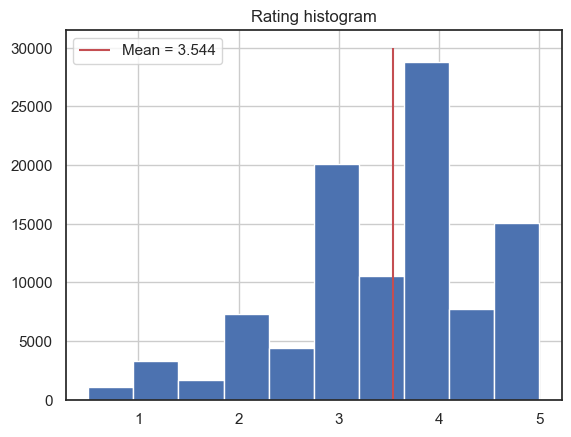

In [8]:
df['rating'].hist(bins=10)
plt.vlines([df['rating'].mean()], ymin=0, ymax=3e4, colors='r', label=f'Mean = {round(df["rating"].mean(), 3)}')
plt.title('Rating histogram')
plt.legend()
plt.show()

### Create PyTorch Dataset

In [9]:
class MovieDataset:
    def __init__(self, users:np.array, movies:np.array, ratings:np.array) -> None:
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self) -> int:
        return len(self.users)

    def __getitem__(self, item:int) -> dict:

        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users), #dtype=torch.long
            "movies": torch.tensor(movies), #dtype=torch.long
            "ratings": torch.tensor(ratings) #dtype=torch.long
        }

In [10]:
# Reset user ID's and movie ID's to starting index 0.
# This avoids index errors
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df['userId'] = lbl_user.fit_transform(df['userId'].values)
df['movieId'] = lbl_movie.fit_transform(df['movieId'].values)

### Train / Test Split

In [11]:
df_train, df_val = model_selection.train_test_split(
    df, test_size=0.2, random_state=33, stratify=df['rating'].values)

df_test, df_val = model_selection.train_test_split(
    df_val, test_size=0.5, random_state=33, stratify=df_val['rating'].values)

In [12]:
train_dataset = MovieDataset(
    users=df_train['userId'].values,
    movies=df_train['movieId'].values,
    ratings=df_train['rating'].values)

val_dataset = MovieDataset(
    users=df_val['userId'].values,
    movies=df_val['movieId'].values,
    ratings=df_val['rating'].values)

test_dataset = MovieDataset(
    users=df_val['userId'].values,
    movies=df_val['movieId'].values,
    ratings=df_val['rating'].values)

print(f'Train: {len(train_dataset)}\nVal: {len(val_dataset)}\nTest: {len(test_dataset)}')

Train: 80003
Val: 10001
Test: 10001


In [13]:
train_dataset.__getitem__(0)

{'users': tensor(29),
 'movies': tensor(1507),
 'ratings': tensor(4., dtype=torch.float64)}

In [14]:
BATCH_SIZE = 512
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

### Define Model

In [15]:
class RecSysModel(nn.Module):
    def __init__(self, n_users:int, n_movies:int, embedding_dim:int) -> None:
        super().__init__()
        self.user_embed = nn.Embedding(num_embeddings=n_users, embedding_dim=embedding_dim)
        self.movie_embed = nn.Embedding(num_embeddings=n_movies, embedding_dim=embedding_dim)
        self.out = nn.Linear(in_features=embedding_dim*2, out_features=1)

    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        embeds_concat = torch.cat([user_embeds, movie_embeds], dim=1)
        output = self.out(embeds_concat)

        return output, user_embeds

In [16]:
EMBEDDING_DIM = 8

model = RecSysModel(
    n_users=n_users,
    n_movies=n_movies,
    embedding_dim=EMBEDDING_DIM
).to(device)

### Train Model

In [17]:
EPOCHS = 30

optimizer = torch.optim.Adam(model.parameters())
# loss_func = nn.MSELoss()

print_prec = 5
n_batches = len(train_loader)
n_batches_val = len(val_loader)
size = len(train_loader.dataset)
size_val = len(val_loader.dataset)
loss_hist, mse_hist, loss_hist_val, mse_hist_val = [], [], [], []
user_embeddings, movie_embeddings = [model.user_embed], [model.movie_embed]
for epoch in range(EPOCHS):
    cost = 0.0
    for i, train_data in enumerate(train_loader):
        # Train
        model.train(True)
        output, _ = model(train_data['users'], train_data['movies'])
        rating = train_data['ratings'].view(BATCH_SIZE, -1).to(torch.float32)

        loss = F.mse_loss(output, rating).sqrt()
        cost += loss.sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    batch_loss = cost / n_batches
    avg_mse = cost / size

    with torch.no_grad():  # no gradients for test data
        val_cost = 0.0
        for i, val_data in enumerate(val_loader):
            output, _ = model(val_data['users'], val_data['movies'])
            rating = val_data['ratings'].view(BATCH_SIZE, -1).to(torch.float32)

            # val_loss = loss_func(output, rating)
            val_loss = F.mse_loss(output, rating).sqrt()
            val_cost += val_loss.sum().item()

            batch_loss_val = val_cost / n_batches_val
            avg_mse_val = val_cost / size_val

    loss_hist.append(batch_loss), loss_hist_val.append(batch_loss_val)

    print(f'epoch: {epoch+1}\ttrain loss: {round(batch_loss, print_prec)}\tval loss: {round(batch_loss_val, print_prec)}')


epoch: 1	train loss: 3.5175	val loss: 3.29877
epoch: 2	train loss: 3.01375	val loss: 2.67053
epoch: 3	train loss: 2.33271	val loss: 2.02987
epoch: 4	train loss: 1.7951	val loss: 1.60563
epoch: 5	train loss: 1.44973	val loss: 1.3351
epoch: 6	train loss: 1.23279	val loss: 1.17124
epoch: 7	train loss: 1.1058	val loss: 1.08092
epoch: 8	train loss: 1.03455	val loss: 1.02496
epoch: 9	train loss: 0.99335	val loss: 0.9953
epoch: 10	train loss: 0.96816	val loss: 0.97534
epoch: 11	train loss: 0.95139	val loss: 0.9606
epoch: 12	train loss: 0.93901	val loss: 0.95033
epoch: 13	train loss: 0.92915	val loss: 0.94432
epoch: 14	train loss: 0.92065	val loss: 0.93491
epoch: 15	train loss: 0.91309	val loss: 0.93165
epoch: 16	train loss: 0.90585	val loss: 0.92663
epoch: 17	train loss: 0.89914	val loss: 0.92358
epoch: 18	train loss: 0.89295	val loss: 0.92378
epoch: 19	train loss: 0.88698	val loss: 0.91994
epoch: 20	train loss: 0.8809	val loss: 0.9162
epoch: 21	train loss: 0.87581	val loss: 0.911
epoch: 22	t

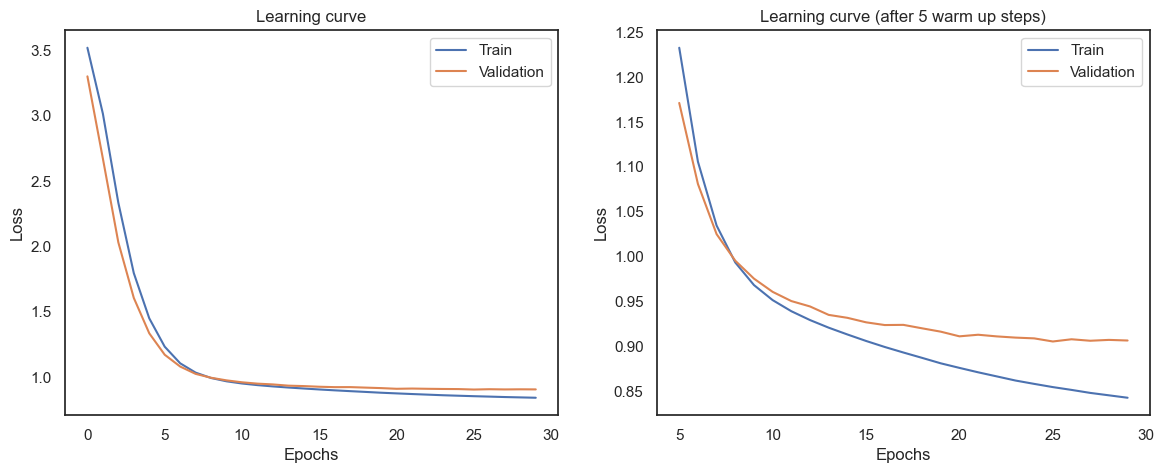

In [18]:
SKIP_WARM_UP_STEPS = 5

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax0.plot(loss_hist, label='Train')
ax0.plot(loss_hist_val, label='Validation')
ax0.set_title('Learning curve')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

ax1.plot(range(SKIP_WARM_UP_STEPS, len(loss_hist)), loss_hist[SKIP_WARM_UP_STEPS:], label='Train')
ax1.plot(range(SKIP_WARM_UP_STEPS, len(loss_hist_val)), loss_hist_val[SKIP_WARM_UP_STEPS:], label='Validation')
ax1.set_title(f'Learning curve (after {SKIP_WARM_UP_STEPS} warm up steps)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
plt.show()

### Store user embeddings

In [19]:
do_save = False

if do_save:

    # torch.Tensor to np.array
    user_embeddings = model.user_embed.weight.detach().numpy()
    user_embeddings.shape

    # saving
    safe_date = datetime.now().strftime('%Y%m%d')
    np.save(f'./data/np_user_embeddings_{safe_date}.npy', user_embeddings)

    print('Embeddings saved!')

## Evaluation

In [20]:
user_est_true = defaultdict(list)

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        users = test_data['users']
        movies = test_data['movies']
        ratings = test_data['ratings']

        model_output, _ = model(test_data['users'],
                             test_data['movies'])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            user_est_true[user_id].append((pred_rating, true_rating))

In [21]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k = 20
    threshold = 4.0

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True) 

        n_rel = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings])
        n_rec_k = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings[:k]])

        n_rel_and_rec_k = sum([((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k]])
        
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

In [22]:
prec_at_k = sum(prec for prec in precisions.values()) / len(precisions)
recall_at_k = sum(rec for rec in recalls.values()) / len(recalls)

print(f'precisions @ {k}: {round(prec_at_k, 4)}')
print(f'recall @ {k}: {round(recall_at_k, 4)}')

precisions @ 20: 0.3851
recall @ 20: 0.355
